# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>



## Целиков Сергей, DST-PRO-11

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

### Установка необходимых пакетов

In [1]:
!pip install -q tensorflow==2.3

#аугментации изображений
!pip install albumentations -q

# Приведение к начальной форме с лемматизацией
!pip install pymorphy2 -q
!pip install pymorphy2-dicts -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_log_error

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import albumentations

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words("russian"))

from tqdm import tqdm
import pymorphy2

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [5]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

In [8]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [9]:
test.nunique()

bodyType                  14
brand                      3
color                     15
description             1540
engineDisplacement        43
enginePower              120
fuelType                   4
mileage                  935
modelDate                 37
model_info               101
name                     536
numberOfDoors              4
productionDate            35
sell_id                 1671
vehicleConfiguration     205
vehicleTransmission        4
Владельцы                  3
Владение                 131
ПТС                        2
Привод                     3
Руль                       1
dtype: int64

In [10]:
# Посмотрим, есть ли пропуски в данных

In [11]:
train.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [12]:
test.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  0
Владение                1092
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

### Посмотрим на возможность преобразования полей 'Владельцы', 'Владение' к числовому формату

In [13]:
train['Владельцы'].unique()

array(['3 или более', '2\xa0владельца', '1\xa0владелец', nan],
      dtype=object)

In [14]:
temp_dict = {'3 или более': 3, '2\xa0владельца': 2, '1\xa0владелец' : 1}
train['owners'] = train['Владельцы'].map(temp_dict)
train['owners'].fillna(0, inplace = True)
print(train['owners'].unique())
train.drop(['owners'], inplace=True, axis=1)

[3. 2. 1. 0.]


In [15]:
def replace_all(text):
    dic = { 'года': '* 12', 'год': '* 12', 'лет': '* 12', 'месяцев' : '', 'месяца' : '', 'месяц' : '', 'и': '+', ' ': ''}
    text = str(text)
    for i, j in dic.items():
        text = text.replace(i, j)
    return int(eval(text))

train['Владение'].fillna('0.0', inplace = True)
train['owning'] = train['Владение'].apply(replace_all)
print(train['owning'].unique())
print(train['owning'].value_counts())
train.drop(['owning'], inplace=True, axis=1)

[  0 102  57  33  81  51  67  14  36  58  15  80  24   7   1  20  21  26
  79  74  29  99  34  27  37  69  98  78 171  28  61 135  10  38  95  64
  41 122  54  71  30  56  76  22  17  35  31  70  89 118  23  32  77  40
   9 100  66  12 101  47  19  52  43 137  53  82  11  16  55  87 116  13
   8  90  44  68 119 110  96 142  59 149  72   4  62  45 173 127  86  46
  75   5  65  85  42  83  91 104  94  50  88  25 163 141  39  84 109 128
 209  18 123   6  92 111 105 103 136 140 113 120  60  73 190  49  48  93
 106 129 108   3   2 144 121 131 143 162 112  97 139 132  63 215 148 117
 107 208 183 159 133 161 176 334 226 138 134 124 158 115 146 153 152 174
 202 223 147 114 126 125 204 196 169 164 130 280]
0      4326
20       54
14       53
9        46
12       46
       ... 
208       1
204       1
196       1
176       1
209       1
Name: owning, Length: 174, dtype: int64


In [16]:
train['Владение'].unique()

array(['0.0', '8 лет и 6 месяцев', '4 года и 9 месяцев',
       '2 года и 9 месяцев', '6 лет и 9 месяцев', '4 года и 3 месяца',
       '5 лет и 7 месяцев', '1 год и 2 месяца', '3 года',
       '4 года и 10 месяцев', '1 год и 3 месяца', '6 лет и 8 месяцев',
       '2 года', '7 месяцев', '1 месяц', '1 год и 8 месяцев',
       '1 год и 9 месяцев', '2 года и 2 месяца', '6 лет и 7 месяцев',
       '6 лет и 2 месяца', '2 года и 5 месяцев', '8 лет и 3 месяца',
       '2 года и 10 месяцев', '2 года и 3 месяца', '3 года и 1 месяц',
       '5 лет и 9 месяцев', '8 лет и 2 месяца', '6 лет и 6 месяцев',
       '14 лет и 3 месяца', '2 года и 4 месяца', '5 лет и 1 месяц',
       '11 лет и 3 месяца', '10 месяцев', '3 года и 2 месяца',
       '7 лет и 11 месяцев', '5 лет и 4 месяца', '3 года и 5 месяцев',
       '10 лет и 2 месяца', '4 года и 6 месяцев', '5 лет и 11 месяцев',
       '2 года и 6 месяцев', '4 года и 8 месяцев', '6 лет и 4 месяца',
       '1 год и 10 месяцев', '1 год и 5 месяцев', '2 года

### Посмотрим на категориальные признаки - есть ли смысл в их предобработке.

In [17]:
my_feature_list = ['bodyType', 'brand', 'color', 'fuelType', 'model_info','numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'engineDisplacement' ]
for item in my_feature_list:
    print(item, train[item].unique())

bodyType ['седан' 'лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'минивэн'
 'универсал 5 дв.' 'купе-хардтоп' 'купе' 'кабриолет' 'родстер'
 'хэтчбек 3 дв.' 'компактвэн' 'пикап двойная кабина'
 'внедорожник открытый' 'седан 2 дв.' 'внедорожник 3 дв.' 'лимузин']
brand ['BMW' 'AUDI' 'MERCEDES']
color ['чёрный' 'серебристый' 'белый' 'синий' 'серый' 'красный' 'коричневый'
 'зелёный' 'голубой' 'пурпурный' 'бежевый' 'фиолетовый' 'оранжевый'
 'золотистый' 'жёлтый' 'розовый']
fuelType ['бензин' 'дизель' 'гибрид' 'электро']
model_info ['5ER' 'A6' 'E_KLASSE' 'A5' 'C_KLASSE' '7ER' '3ER' 'X4' 'M_KLASSE'
 'S_KLASSE_AMG' 'Q5' 'CLA_KLASSE' 'GLA_CLASS' 'X1' 'Q7' 'X2' 'X5'
 'B_KLASSE' 'X6_M' 'S_KLASSE' 'VITO' 'A3' '1ER' 'CLS_KLASSE' 'X6'
 'S_CLASS_MAYBACH' 'CL_KLASSE' 'G_KLASSE_AMG' 'GLC_KLASSE' 'GLS_KLASSE'
 'A8' 'A4' 'GLE_KLASSE_COUPE_AMG' 'X3' 'Q3' 'X7' 'G_KLASSE'
 'GLS_KLASSE_AMG' 'I3' 'VIANO' 'GL_KLASSE' 'V_KLASSE' 'SLK_KLASSE'
 'GLC_COUPE' 'CLS_KLASSE_AMG' 'A_KLASSE' 'S7' '4' 'A7' '6ER' 'RS6'
 'M_KL

### Посмотрим, удастся ли извлечь какую-либо информацию из поля 'name'

In [18]:
train['name'].nunique()

900

In [19]:
train['name'].value_counts()

200 2.0 AT (184 л.с.)         121
35i 3.0 AT (306 л.с.) 4WD     116
2.0 AMT (211 л.с.) 4WD        113
30d 3.0d AT (249 л.с.) 4WD     87
400 3.0 AT (333 л.с.) 4WD      76
                             ... 
400 3.5 AT (333 л.с.) 4WD       1
1.9 MT (140 л.с.)               1
350 3.0d AT (235 л.с.) 4WD      1
L1 3.0d AT (204 л.с.)           1
745d 4.4d AT (329 л.с.)         1
Name: name, Length: 900, dtype: int64

In [20]:
train['name'].unique()

array(['530xi 3.0 AT (272 л.с.) 4WD', '2.8 CVT (204 л.с.)',
       '350 3.5 AT (306 л.с.) 4WD', '2.0 CVT (180 л.с.)',
       '1.8 CVT (160 л.с.)', '200 1.8 AT (184 л.с.)',
       '200 2.0 AT (197 л.с.) 4WD', '740Li xDrive 3.0 AT (326 л.с.) 4WD',
       '1.8 AMT (190 л.с.)', '320d xDrive 2.0d AT (184 л.с.) 4WD',
       '28i 2.0 AT (245 л.с.) 4WD', '320 3.0d AT (224 л.с.) 4WD',
       '63 AMG Long 5.5 AT (585 л.с.) 4WD', '2.0 AMT (211 л.с.) 4WD',
       '2.0 AMT (225 л.с.) 4WD', '525i 2.5 AT (218 л.с.)',
       '528i 2.0 AT (245 л.с.)', '200 1.6 AMT (156 л.с.)',
       '250 2.0 AMT (211 л.с.) 4WD', '3.0d AMT (245 л.с.) 4WD',
       '730d 3.0d AT (231 л.с.)', '20i 2.0 AT (184 л.с.) 4WD',
       '3.0d AT (238 л.с.) 4WD', 'sDrive18i 1.5 AMT (140 л.с.)',
       '320i 2.0 AT (150 л.с.)', '4.8is 4.8 AT (360 л.с.) 4WD',
       '180 1.6 AMT (122 л.с.)', '30d 3.0d AT (245 л.с.) 4WD',
       '4.4 AT (555 л.с.) 4WD', '2.0 AMT (249 л.с.) 4WD',
       '530i xDrive 2.0 AT (249 л.с.) 4WD', '325xi 2.5 A

###  Основная часть информации в данном поле представлена в других полях, можно попытаться использовать его как категориальное, уменьшив размерность с помощью хэширования

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [21]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [22]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

### Проведем анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

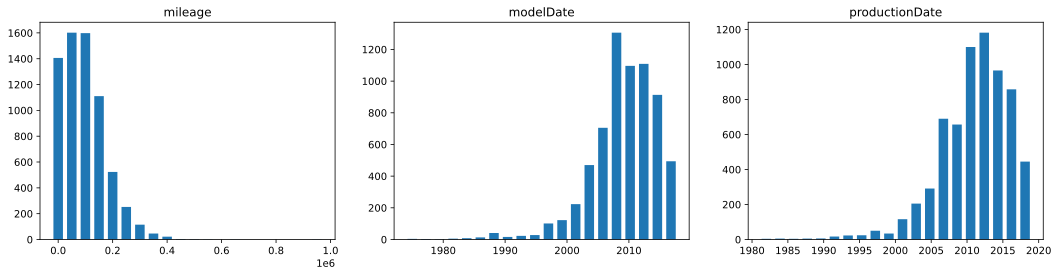

In [23]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
        columns = min(3, len(titles_values_dict))
        rows = (len(titles_values_dict) - 1) // columns + 1
        fig = plt.figure(figsize = (columns * 6, rows * 4))
        for i, (title, values) in enumerate(titles_values_dict.items()):
            hist, bins = np.histogram(values, bins = 20)
            ax = fig.add_subplot(rows, columns, i + 1)
            ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
            ax.set_title(title)
        plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

In [24]:
# визуализируем числовые признаки
def visualize(data, col, size=6):
    fig, ax = plt.subplots(2, 2, figsize=(2*size, 2*size))
    fig.suptitle('Histogram and boxplot for {0} '.format(col), fontsize=20)
    ax[0, 0].hist(data[col], bins=20, histtype='bar', align='mid',
                  rwidth=0.8, color='blue')  # гистограмма
    ax[0, 1].boxplot(data[col], vert=False)
    ax[1, 0].hist(np.log(data[col] + 1), bins=20, histtype='bar',
                  align='mid', rwidth=0.8, color='blue')  # гистограмма
    ax[1, 1].boxplot(np.log(data[col] + 1), vert=False)  # выбросы
    ax[1, 0].set(title='log (' + col + ')')
    ax[1, 1].set(title='log (' + col + ')')
    ax[0, 0].set(title=col)
    ax[0, 1].set(title=col)
    plt.figtext(0.5, 0, col, fontsize=16)
    plt.show()


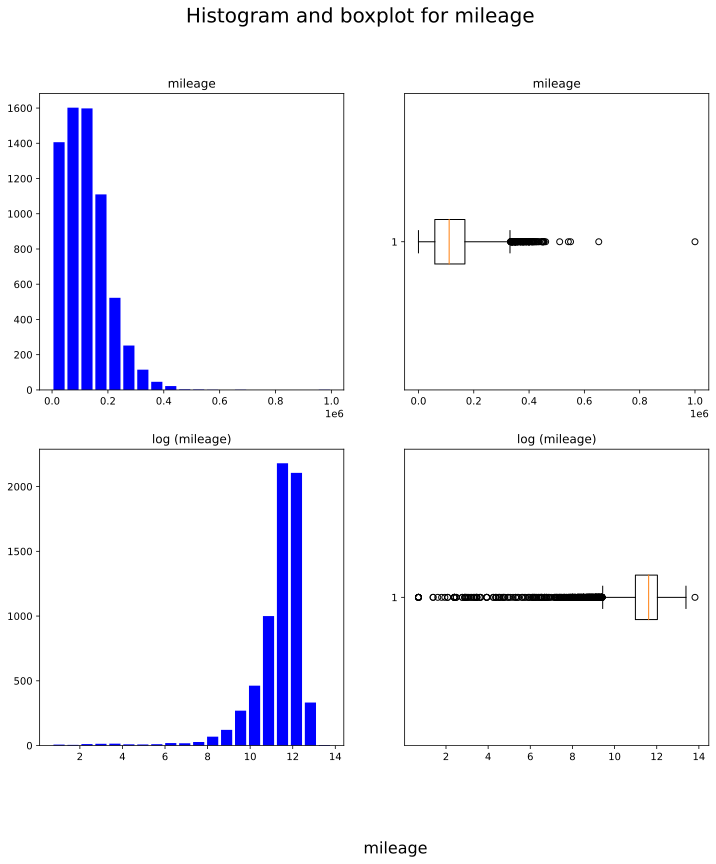

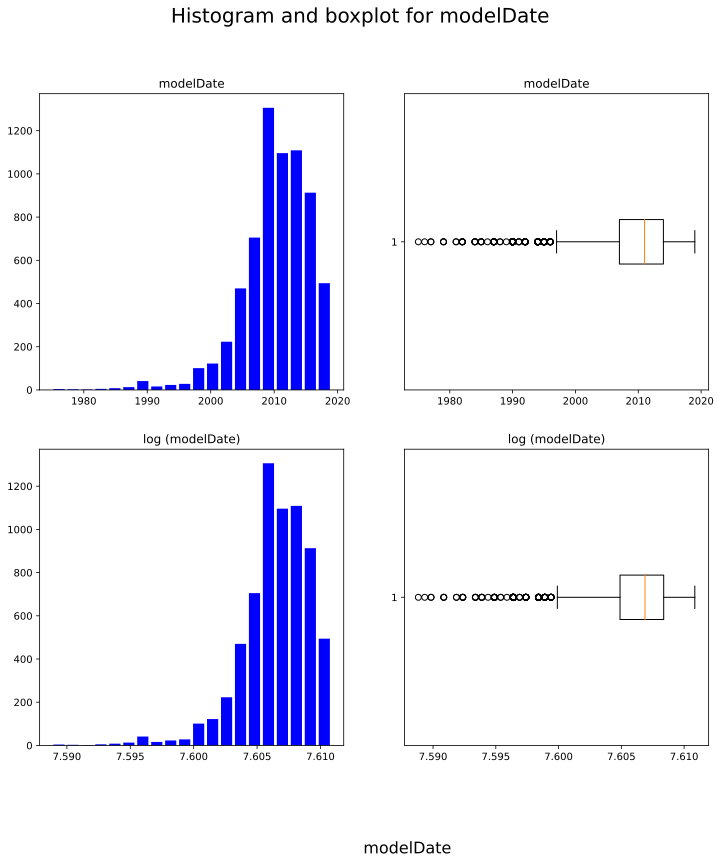

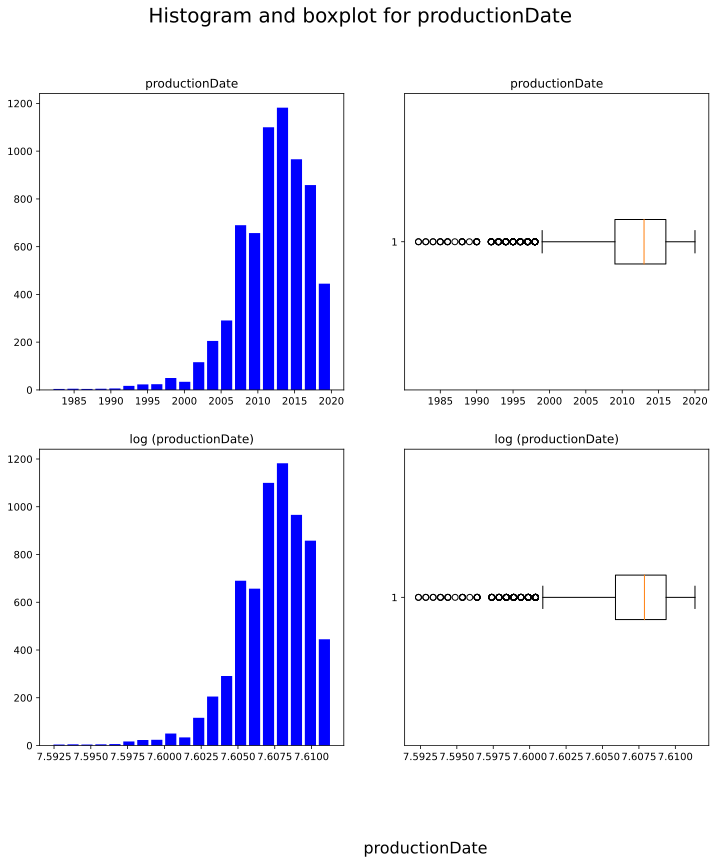

In [25]:
visualize(train, 'mileage')
visualize(train, 'modelDate')
visualize(train, 'productionDate')

In [26]:
# Вывод - мы имеем логнормальное распределение, возьмем логарифм от признака.

### У нас есть два признака, обозначающих дату - modelDate и productionDate.

### Очевидно, что они взаимосвязаны. Заменим признак productionDate на разницу productionDate - modelDate

In [27]:
train['modelAge'] = train['productionDate'] - train['modelDate']

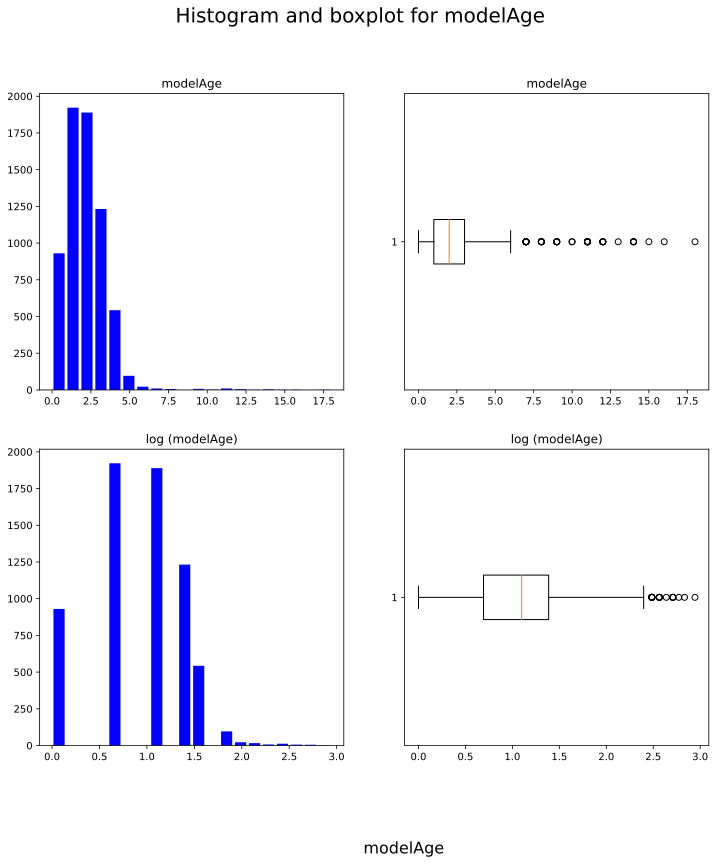

In [28]:
visualize(train, 'modelAge')

### Вывод - мы имеем логнормальное распределение, возьмем логарифм от признака.


### Приведем признаки к числовым

In [29]:
#  Вспомогательная функция для приведения признака 'Владение' в числовой вид - вычисление длительности владения.
def replace_all(text):
        dic = { 'года': '* 12', 'год': '* 12', 'лет': '* 12', 'месяцев' : '', 'месяца' : '', 'месяц' : '', 'и': '+', ' ': ''}
        text = str(text)
        for i, j in dic.items():
            text = text.replace(i, j)
        return int(eval(text))


# Исправление признака engineDisplacement
# Преобразуем данный признак в числовой
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: '0.0 LTR' if x == ' LTR' else x)
train['eng_disp_num'] = (train['engineDisplacement'].str.split())
train['eng_disp_num'] = train['eng_disp_num'].apply(lambda x: float(x[0]) if x[0] != 'undefined' else 0)

    
# Исправление признака enginePower
# Преобразуем данный признак в числовой
train['eng_pow_num'] = (train['enginePower'].str.split())
train['eng_pow_num'] = train['eng_pow_num'].apply(lambda x: float(x[0]))

    
    
# У нас есть два признака, обозначающих дату - modelDate и productionDate.
# Очевидно, что они взаимосвязаны. Заменим признак modelDate на разницу productionDate - modelDate
# посчитаем, сколько лет выпускалась модель ко времени производства.
train['modelAge'] = train['productionDate'] - train['modelDate']

    
# посчитаем, как давно выпущена данная машина.
train['modelOld'] = train['productionDate'].apply(lambda x: pd.Timestamp.today().year - x)
    
# посчитаем среднегодовой пробег автомобиля.
train['milesPerYear'] = train['mileage'] / train['modelOld']
    
# Преобразуем признак 'Владельцы' в числовой
temp_dict = {'3 или более': 3, '2\xa0владельца': 2, '1\xa0владелец' : 1}
train['owners'] = train['Владельцы'].map(temp_dict)
train['owners'].fillna(0, inplace = True)

    
# Преобразуем признак 'Владение' в числовой
train['Владение'].fillna('0.0', inplace = True)
train['owning'] = train['Владение'].apply(replace_all)


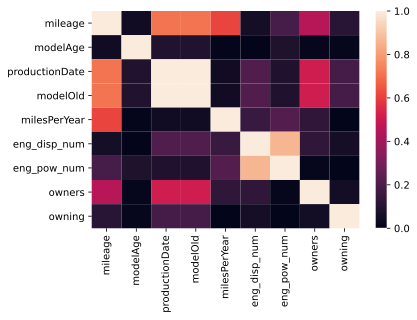

In [30]:
num_cols = ['mileage', 'modelAge', 'productionDate', 'modelOld', 'milesPerYear', \
                      'eng_disp_num', 'eng_pow_num', 'owners', 'owning']

# Оценим корреляцию Пирсона для непрерывных переменных
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1);


### Вывод - некоторые признаки сильно скоррелированы, желательно их исследовать далее

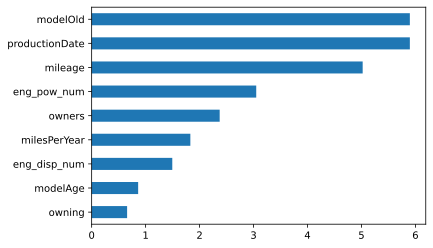

In [31]:
# Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

imp_num = pd.Series(f_classif(train[num_cols], train['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

### Вывод - некоторые признаки (modelAge, owning) имеют малое влияние - кандидаты на удаление.

### Исследуем категориальные признаки

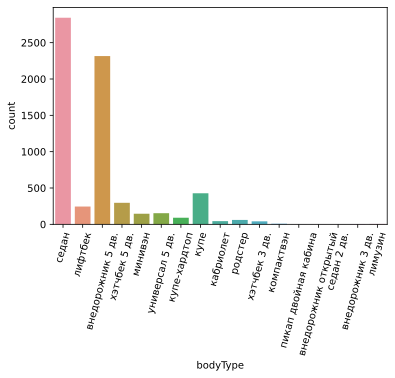

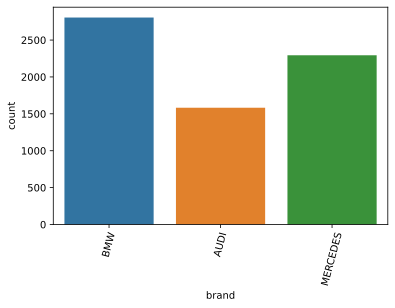

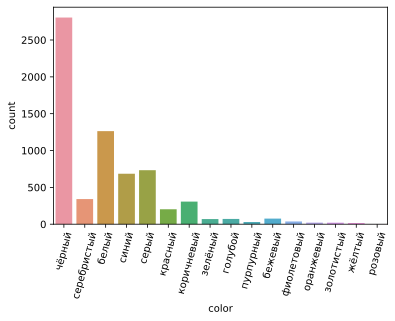

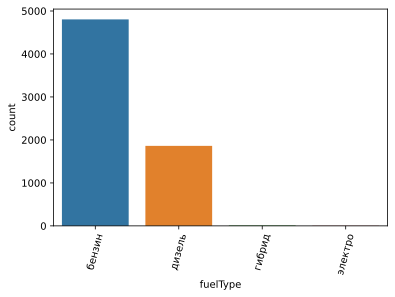

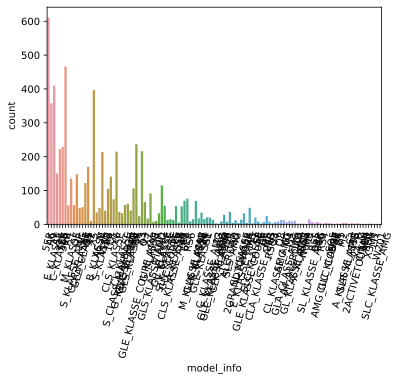

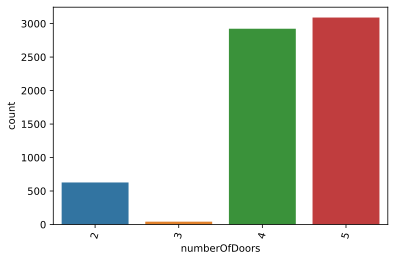

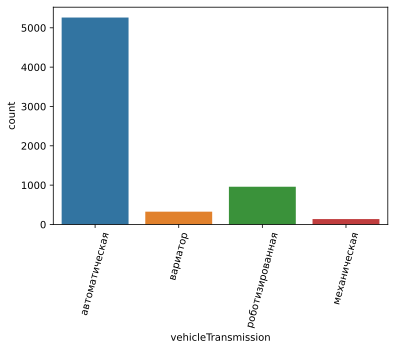

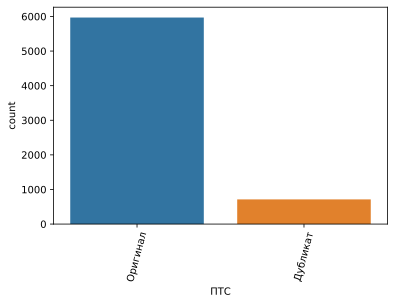

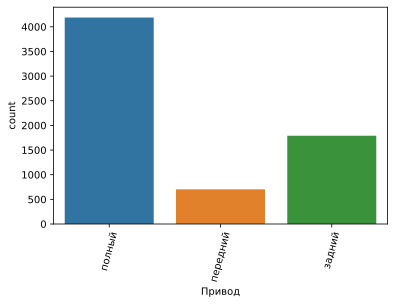

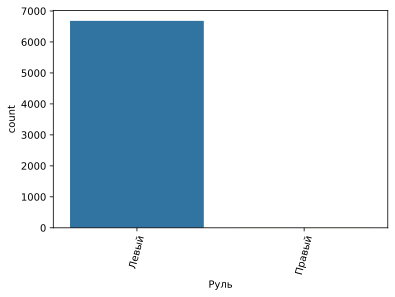

In [32]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль']
for col in cat_cols:
    sns.countplot(x=train[col])
    plt.xticks(rotation=75)
    plt.show()

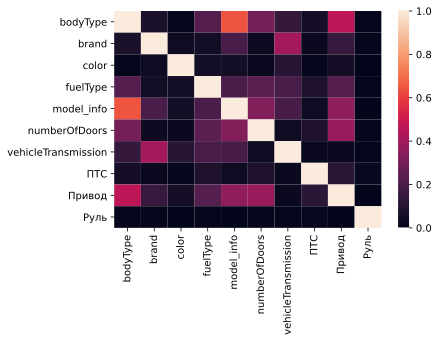

In [33]:
# Оценим взаимную корреляцию категориальных признаков

# заменяем строковые значения в категориальных столбцах на числовые

encoder = LabelEncoder()

for column in cat_cols:
    encoder.fit(train[column])
    train[column] = encoder.transform(train[column])

sns.heatmap(train[cat_cols].corr().abs(), vmin=0, vmax=1);

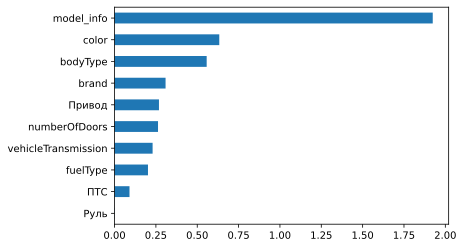

In [34]:
# проверим значимость категориальных признаков

imp_cat = pd.Series(mutual_info_classif(train[cat_cols], train['price'],
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

### Вывод - влияние некоторых категориальных признаков минимально.

# PreProc Tabular Data

### Загрузим данные заново для проведения окончательной подготовки.

In [5]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [6]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


# Подготовка данных

In [7]:
#  Вспомогательная функция для приведения признака 'Владение' в числовой вид - вычисление длительности владения.
def replace_all(text):
        dic = { 'года': '* 12', 'год': '* 12', 'лет': '* 12', 'месяцев' : '', 'месяца' : '', 'месяц' : '', 'и': '+', ' ': ''}
        text = str(text)
        for i, j in dic.items():
            text = text.replace(i, j)
        return int(eval(text))


# Подготовка данных

# используем текстовые признаки как категориальные
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'is_owning']  # 'hash_name'

# используем  числовые признаки
numerical_features = ['mileage', 'modelAge', 'productionDate', 'modelOld', 'milesPerYear', \
                      'eng_disp_num', 'eng_pow_num', 'owners', 'owning']

numerical_features_log = ['mileage', 'modelAge', 'productionDate', 'modelOld']



def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    
    # Исправление признака engineDisplacement
    # Преобразуем данный признак в числовой
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: '0.0 LTR' if x == ' LTR' else x)
    df_output['eng_disp_num'] = (df_output['engineDisplacement'].str.split())
    df_output['eng_disp_num'] = df_output['eng_disp_num'].apply(lambda x: float(x[0]) if x[0] != 'undefined' else 0)
    df_output.drop(['engineDisplacement'], inplace=True, axis=1)
    
    # Исправление признака enginePower
    # Преобразуем данный признак в числовой
    df_output['eng_pow_num'] = (df_output['enginePower'].str.split())
    df_output['eng_pow_num'] = df_output['eng_pow_num'].apply(lambda x: float(x[0]))
    df_output.drop(['enginePower'], inplace=True, axis=1)
    

    # ################### Новые признаки ####################################################
    
    # У нас есть два признака, обозначающих дату - modelDate и productionDate.
    # Очевидно, что они взаимосвязаны. Заменим признак modelDate на разницу productionDate - modelDate
    # посчитаем, сколько лет выпускалась модель ко времени производства.
    df_output['modelAge'] = df_output['productionDate'] - df_output['modelDate']
    df_output['modelAge'] = df_output['modelAge'].apply(lambda x: 0 if x < 0 else x)
    df_output.drop(['modelDate'], inplace=True, axis=1)
    
    # посчитаем, как давно выпущена данная машина.
    df_output['modelOld'] = df_output['productionDate'].apply(lambda x: pd.Timestamp.today().year - x)
    
    # посчитаем среднегодовой пробег автомобиля.
    df_output['milesPerYear'] = df_output['mileage'] / df_output['modelOld']
    
    # Преобразуем признак 'Владельцы' в числовой
    temp_dict = {'3 или более': 3, '2\xa0владельца': 2, '1\xa0владелец' : 1}
    df_output['owners'] = df_output['Владельцы'].map(temp_dict)
    df_output['owners'].fillna(0, inplace = True)
    df_output.drop(['Владельцы'], inplace=True, axis=1)
    
    # Преобразуем признак 'Владение' в числовой
    df_output['Владение'].fillna('0.0', inplace = True)
    df_output['owning'] = df_output['Владение'].apply(replace_all)
    df_output.drop(['Владение'], inplace=True, axis=1)
    
    # Создадим новый бинарный признак  - есть ли данные в признаке 'Владение' 
    # Необходим, так как признак 'Владение' заполнен только у очень малого количества примеров
    df_output['is_owning'] = df_output['owning'].apply(lambda x: 0 if x == 0 else 1)
    
    # Нормализация данных, логарифмирование числовых признаков.
    # Для данной модели тестирование показало, что логарифмирование ведет к ухудшению качества модели.
    # Поэтому не будем этого делать.
    # for column in numerical_features_log:
    #    df_output[column] = np.log(df_output[column] + 1)
    
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    # ################### Feature Engineering ####################################################
    # Попробуем создать категориальные признаки из поля 'name' и уменьшить их размерность с помощью хэширования
    # поскольку уникальных занчений достаточно много (около 1000) и информация в них дублируется в других полях.
    
    # В итоге - не дает прибавку в качестве обучения либо она очень нестабильна.
    # Не будем проводить подобную подготовку.
    # hash_space = 200
    # df_output['hash_name'] = df_output['name'].apply(lambda s: hash(s) % hash_space)
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые были обработаны ранее , 
    df_output.drop(['name','vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [8]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,mileage,productionDate,sample,price,eng_disp_num,eng_pow_num,modelAge,modelOld,milesPerYear,owners,...,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,is_owning_0,is_owning_1
7399,0.106999,0.868421,1,1590000.0,0.303030,0.2720,0.055556,0.131579,0.231830,0.333333,...,0,0,1,0,0,1,1,0,0,1
4273,0.044999,0.894737,1,3100000.0,0.303030,0.2720,0.166667,0.105263,0.116996,0.333333,...,0,0,1,0,0,1,1,0,0,1
3362,0.054999,0.868421,1,3750000.0,0.833333,0.8160,0.111111,0.131579,0.119163,1.000000,...,0,0,1,0,0,1,1,0,1,0
2794,0.124999,0.763158,1,1990000.0,0.454545,0.2720,0.000000,0.236842,0.162497,1.000000,...,1,0,1,0,0,1,1,0,1,0
5378,0.148999,0.868421,1,1285000.0,0.303030,0.2288,0.111111,0.131579,0.322831,1.000000,...,0,0,1,0,0,1,1,0,1,0
5902,0.069799,0.815789,1,3399999.0,0.606061,0.7760,0.055556,0.184211,0.113421,0.333333,...,0,0,1,0,0,1,1,0,1,0
1454,0.052765,0.868421,0,0.0,0.454545,0.3920,0.166667,0.131579,0.114323,0.666667,...,0,0,1,0,0,1,1,0,1,0
2476,0.173499,0.684211,1,700000.0,0.378788,0.2288,0.055556,0.315789,0.173497,1.000000,...,0,1,0,1,0,0,1,0,0,1
743,0.119999,0.736842,0,0.0,0.242424,0.0640,0.166667,0.263158,0.141815,1.000000,...,0,0,1,1,0,0,1,0,1,0
1168,0.035999,0.842105,0,0.0,0.833333,0.7504,0.111111,0.157895,0.066853,1.000000,...,0,0,1,0,0,1,1,0,1,0


In [39]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 190 entries, mileage to is_owning_1
dtypes: float64(10), int64(1), uint8(179)
memory usage: 2.1 MB


In [40]:
print(list(df_preproc.columns))

['mileage', 'productionDate', 'sample', 'price', 'eng_disp_num', 'eng_pow_num', 'modelAge', 'modelOld', 'milesPerYear', 'owners', 'owning', 'bodyType_0', 'bodyType_1', 'bodyType_2', 'bodyType_3', 'bodyType_4', 'bodyType_5', 'bodyType_6', 'bodyType_7', 'bodyType_8', 'bodyType_9', 'bodyType_10', 'bodyType_11', 'bodyType_12', 'bodyType_13', 'bodyType_14', 'bodyType_15', 'bodyType_16', 'brand_0', 'brand_1', 'brand_2', 'color_0', 'color_1', 'color_2', 'color_3', 'color_4', 'color_5', 'color_6', 'color_7', 'color_8', 'color_9', 'color_10', 'color_11', 'color_12', 'color_13', 'color_14', 'color_15', 'fuelType_0', 'fuelType_1', 'fuelType_2', 'fuelType_3', 'model_info_0', 'model_info_1', 'model_info_2', 'model_info_3', 'model_info_4', 'model_info_5', 'model_info_6', 'model_info_7', 'model_info_8', 'model_info_9', 'model_info_10', 'model_info_11', 'model_info_12', 'model_info_13', 'model_info_14', 'model_info_15', 'model_info_16', 'model_info_17', 'model_info_18', 'model_info_19', 'model_info_20

## Split data

In [9]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [42]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 189 entries, mileage to is_owning_1
dtypes: float64(10), uint8(179)
memory usage: 435.7 KB


# Model 2: CatBoostRegressor

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [11]:
%%time
model = CatBoostRegressor(iterations = 10000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          # task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

Learning rate set to 0.015242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9930294	test: 1.0169907	best: 1.0169907 (0)	total: 54.4ms	remaining: 9m 4s
100:	learn: 0.3927213	test: 0.3973158	best: 0.3973158 (100)	total: 375ms	remaining: 36.8s
200:	learn: 0.2653833	test: 0.2635327	best: 0.2635327 (200)	total: 681ms	remaining: 33.2s
300:	learn: 0.2339221	test: 0.2313923	best: 0.2313923 (300)	total: 1s	remaining: 32.4s
400:	learn: 0.2087605	test: 0.2060526	best: 0.2060526 (400)	total: 1.3s	remaining: 31.2s
500:	learn: 0.1916908	test: 0.1900775	best: 0.1900775 (500)	total: 1.6s	remaining: 30.4s
600:	learn: 0.1818036	test: 0.1806144	best: 0.1806144 (600)	total: 1.95s	remaining: 30.4s
700:	learn: 0.1768580	test: 0.1758790	best: 0.1758790 (700)	total: 2.3s	remaining: 30.5s
800:	learn: 0.1709246	test: 0.1704701	best: 0.1704701 (800)	total: 2.6s	remaining: 29.9s
900:	learn: 0.1648641	test: 0.1652390	best: 0.1652390 (900)	total: 2.92s	remaining: 29.5s
1000:	learn: 0.1599974	test: 0.1612988	best: 0.1612983 (999)	total: 3.34s	remaining: 30s
1100:	learn: 0.155732

In [12]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.92%


TEST mape: 12.92%

In [13]:
# Submission
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3. Попробуем использовать пакет LightAutoML от Сбербанка

In [91]:
# LightAutoML from Sberbank
!pip install lightautoml -q

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

allennlp 1.0.0 requires transformers<2.12,>=2.9, but you'll have transformers 4.8.2 which is incompatible.
huggingface-hub 0.0.12 requires packaging>=20.9, but you'll have packaging 20.1 which is incompatible.
poetry-core 1.0.3 requires importlib-metadata<2.0.0,>=1.7.0; python_version >= "2.7" and python_version < "2.8" or python_version >= "3.5" and python_version < "3.8", but you'll have importlib-metadata 1.6.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [92]:
# LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

# Задаем параметры модели

N_THREADS = 4 
N_FOLDS = 5 
TIMEOUT = 7200 

np.random.seed(RANDOM_SEED)

In [93]:
# Создаем задание
task = Task('reg', loss = 'rmsle', metric = 'rmsle')
#task = Task('reg', loss = 'mape', metric = 'mape', greater_is_better = True)

# Создаем роли
roles = {'target': 'price'}

In [49]:
# Разделим данные для обучения

In [94]:
Xy_train, Xy_test = train_test_split(train_data, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [95]:
%%time
automl = TabularAutoML(task = task, 
                    timeout = TIMEOUT,
                    cpu_limit = N_THREADS,
                    verbose = 1)
oof_pred = automl.fit_predict(Xy_train, roles = roles)

test_pred = automl.predict(Xy_test)

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use

CPU times: user 18min 32s, sys: 5min 41s, total: 24min 13s
Wall time: 14min 34s


In [96]:
lama_full = test_pred.data[:, 0].copy().round(0)
print(f"TEST mape: {(mape(Xy_test['price'].values, lama_full))*100:0.2f}%")

TEST mape: 11.77%


TEST mape: 11.77%

Kaggle mape: 12.18%

In [97]:
sub_predict_automl = automl.predict(X_sub).data[:, 0].copy().round(0)
sample_submission['price'] = sub_predict_automl
sample_submission.to_csv('lama_submission.csv', index=False)

# Model 4: Tabular NN

Построим обычную сеть:

In [14]:
X_train.head(5)

,mileage,productionDate,eng_disp_num,eng_pow_num,modelAge,modelOld,milesPerYear,owners,owning,bodyType_0,...,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,is_owning_0,is_owning_1
7320,0.149999,0.763158,0.909091,0.7504,0.166667,0.236842,0.194997,0.333333,0.315493,0,...,0,0,1,1,0,0,1,0,0,1
8037,0.020941,0.947368,0.303030,0.2720,0.111111,0.052632,0.090745,0.333333,0.000000,0,...,0,0,1,0,0,1,1,0,1,0
4681,0.133896,0.631579,0.469697,0.2880,0.111111,0.368421,0.116040,1.000000,0.000000,0,...,0,0,1,0,0,1,1,0,1,0
6014,0.329999,0.657895,0.272727,0.1744,0.055556,0.342105,0.306426,1.000000,0.222535,0,...,0,0,1,1,0,0,1,0,0,1
3649,0.125999,0.815789,0.454545,0.3808,0.111111,0.184211,0.204747,0.333333,0.219718,0,...,0,0,1,0,0,1,1,0,0,1


## Simple Dense NN

In [15]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               96768     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 228,353
Trainable params: 228,353
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [18]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [19]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=1000, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

CPU times: user 32.3 s, sys: 4.21 s, total: 36.5 s
Wall time: 34.5 s


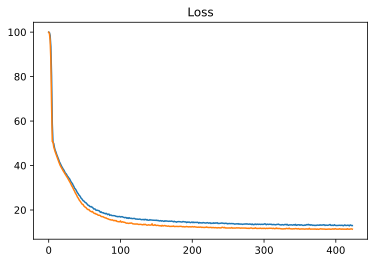

In [20]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [21]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [22]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.37%


TEST mape: 11.07%

Kaggle mape: 11.92%

При использовании только CPU (без GPU) результат получается лучше

In [23]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 5: NLP + Multiple Inputs

In [24]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [25]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [26]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [27]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.46 s, sys: 2.45 ms, total: 1.47 s
Wall time: 1.47 s


In [28]:
# tokenize.word_index

In [28]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.45 s, sys: 3.95 ms, total: 1.46 s
Wall time: 1.45 s


In [29]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [30]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [31]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [32]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [33]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [34]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [35]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [36]:
%%time
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 5s 435ms/step - loss: 99.9927 - MAPE: 99.9927 - val_loss: 99.9076 - val_MAPE: 99.9076
Epoch 2/500
12/12 [==============================] - 5s 379ms/step - loss: 99.0515 - MAPE: 99.0515 - val_loss: 95.4160 - val_MAPE: 95.4160
Epoch 3/500
12/12 [==============================] - 4s 362ms/step - loss: 83.9857 - MAPE: 83.9857 - val_loss: 56.2627 - val_MAPE: 56.2627
Epoch 4/500
12/12 [==============================] - 5s 382ms/step - loss: 53.6156 - MAPE: 53.6156 - val_loss: 50.8544 - val_MAPE: 50.8544
Epoch 5/500
12/12 [==============================] - 4s 365ms/step - loss: 48.7808 - MAPE: 48.7808 - val_loss: 47.3834 - val_MAPE: 47.3834
Epoch 6/500
12/12 [==============================] - 5s 394ms/step - loss: 46.3013 - MAPE: 46.3013 - val_loss: 44.9083 - val_MAPE: 44.9083
Epoch 7/500
12/12 [==============================] - 4s 363ms/step - loss: 43.8490 - MAPE: 43.8490 - val_loss: 42.8290 - val_MAPE: 42.8290
Epoch 8/500
12/12 [========

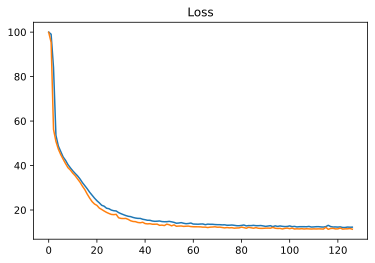

In [37]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [38]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [39]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.38%


TEST mape: 11.38%

Kaggle mape:12.23%


In [40]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 6: NLP + Multiple Inputs + Lemmatizing

### Сделаем Лемматизацию текста

In [41]:
morph = pymorphy2.MorphAnalyzer()

# функция для лемматизации русского текста
def preprocess(X):
    X_proccess = []
    for x in tqdm(X):
        x = x.lower()
        x = nltk.word_tokenize(x)
        x = [word for word in x if word.isalnum()]
        x = [morph.parse(word)[0].normal_form for word in x if not word in stop_words]
        X_proccess.append(' '.join(x))
    return X_proccess


In [42]:
data['description_lemm'] = preprocess(data['description'])

100%|██████████| 8353/8353 [02:59<00:00, 46.50it/s]


In [43]:
# split данных
text_train = data['description_lemm'].iloc[X_train.index]
text_test = data['description_lemm'].iloc[X_test.index]
text_sub = data['description_lemm'].iloc[X_sub.index]

In [44]:
%%time
tokenize_lemm = Tokenizer(num_words=MAX_WORDS)
tokenize_lemm.fit_on_texts(data['description_lemm'])
#data.drop(['description_lemm'], inplace=True, axis=1)

CPU times: user 1.3 s, sys: 0 ns, total: 1.3 s
Wall time: 1.32 s


In [45]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize_lemm.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize_lemm.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize_lemm.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


In [46]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобиль проверить 110 пункт автокредит специальный ставка ауди центр север официальный дилер audi входящий группа компания рольф являться один крупный дилер европа предлагать ряд услуга покупка продажа автомобиль пробег протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди дилер audi россия предоставлять клиент самый большой выбор автомобиль пробег audi другой марка каждый автомобиль проходить тщательный диагностик подготовка гарантировать находиться отличный состояние убедиться правильный выбор возможность пройти ознакомительный поездка интересовать автомобиль смочь ознакомиться автомобиль выходить дом наш менеджер провести online презентация видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условие специалист компания подобрать хороший условие кредитование 6 000 проверить автомобиль пробег гарантия 2 год ждать сайт мобильный приложение рольф
[   0    0 

In [47]:
# RNN NLP
model_nlp_lemm = Sequential()
model_nlp_lemm.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp_lemm.add(L.Embedding(len(tokenize_lemm.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp_lemm.add(L.LSTM(256, return_sequences=True))
model_nlp_lemm.add(L.Dropout(0.5))
model_nlp_lemm.add(L.LSTM(128,))
model_nlp_lemm.add(L.Dropout(0.25))
model_nlp_lemm.add(L.Dense(64, activation="relu"))
model_nlp_lemm.add(L.Dropout(0.25))

In [48]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [49]:
# Multiple Inputs NN
combinedInput = L.concatenate([model_nlp_lemm.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp_lemm.input, model_mlp.input], outputs=head)

In [50]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 256)     5421568     seq_description[0][0]            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 256, 256)     525312      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 256, 256)     0           lstm_2[0][0]                     
_______________________________________________________________________________________

In [51]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [52]:
%%time
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 301ms/step - loss: 99.9844 - MAPE: 99.9844 - val_loss: 99.8160 - val_MAPE: 99.8160
Epoch 2/500
12/12 [==============================] - 3s 247ms/step - loss: 98.3669 - MAPE: 98.3669 - val_loss: 92.5355 - val_MAPE: 92.5355
Epoch 3/500
12/12 [==============================] - 3s 236ms/step - loss: 76.0644 - MAPE: 76.0644 - val_loss: 50.3438 - val_MAPE: 50.3438
Epoch 4/500
12/12 [==============================] - 3s 249ms/step - loss: 52.9796 - MAPE: 52.9796 - val_loss: 48.4227 - val_MAPE: 48.4227
Epoch 5/500
12/12 [==============================] - 3s 259ms/step - loss: 47.9688 - MAPE: 47.9688 - val_loss: 46.1026 - val_MAPE: 46.1026
Epoch 6/500
12/12 [==============================] - 3s 243ms/step - loss: 45.4921 - MAPE: 45.4921 - val_loss: 43.9312 - val_MAPE: 43.9312
Epoch 7/500
12/12 [==============================] - 3s 248ms/step - loss: 43.3089 - MAPE: 43.3089 - val_loss: 41.8794 - val_MAPE: 41.8794
Epoch 8/500
12/12 [========

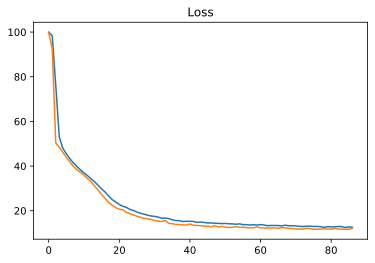

In [53]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [54]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp_lemm.hdf5')

In [56]:
test_predict_nn2_lemm = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2_lemm[:,0]))*100:0.2f}%")

TEST mape: 12.12%


TEST mape: 11.12%

Kaggle mape: 12.23%

In [57]:
sub_predict_nn2_lemm = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2_lemm[:,0]
sample_submission.to_csv('nn2_lemm_submission.csv', index=False)

# Model 7: Добавляем картинки + Augmentation +Lemmatizing

### Data

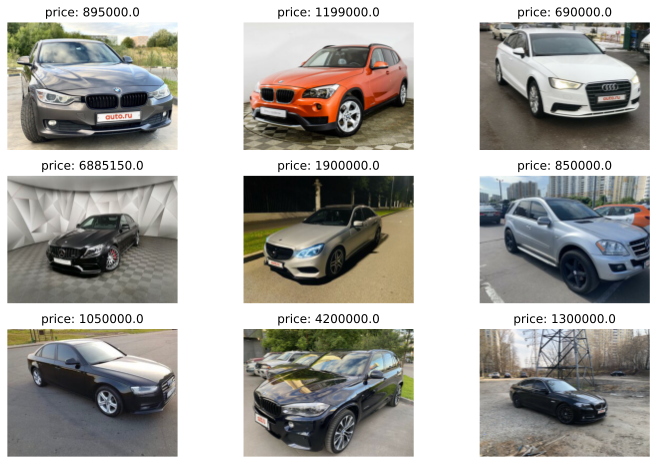

In [58]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [59]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in tqdm(enumerate(data['sell_id'].iloc[index].values)):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

5679it [00:58, 96.29it/s] 
10it [00:00, 98.53it/s]

images shape (5679, 240, 320, 3) dtype uint8


1003it [00:10, 93.28it/s]
10it [00:00, 94.51it/s]

images shape (1003, 240, 320, 3) dtype uint8


1671it [00:17, 95.73it/s] 


images shape (1671, 240, 320, 3) dtype uint8


### albumentations

In [60]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, RandomBrightness, RGBShift, ElasticTransform
)


### Модифицируем функцию аугментации

In [61]:
# Модифицируем функцию аугментации

augmentation = Compose([
    #Transpose(),
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.35, rotate_limit=15, p=0.9),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
        ElasticTransform(p=0.3)
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(p=0.9),
        RandomBrightness(p=1),
        RGBShift(p=1)
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=0.9)


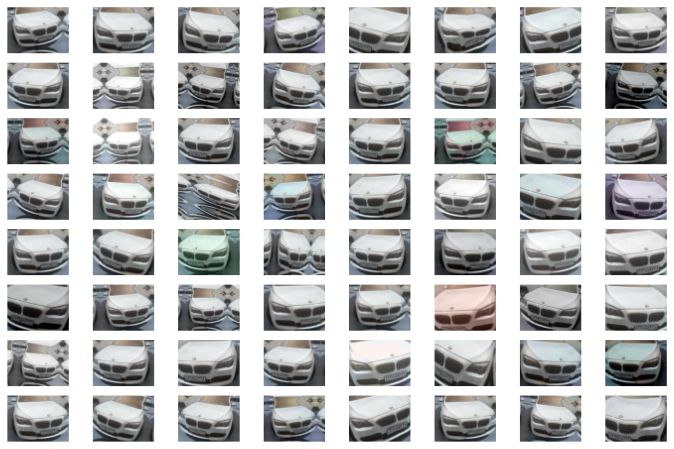

In [62]:
#пример
plt.figure(figsize = (12,8))
for i in range(64):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(8, 8, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

## Используем проведенную ранее лемматизацию текста

In [63]:
# NLP part

# Используем проведенную ранее лемматизацию текста
tokenize_lemm = Tokenizer(num_words=MAX_WORDS)
tokenize_lemm.fit_on_texts(data['description_lemm'])
#tokenize.fit_on_texts(data.description)

In [64]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize_lemm.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [65]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [66]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [67]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize_lemm.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [68]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [69]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [70]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [71]:
%%time
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 132s 696ms/step - loss: 56.0860 - MAPE: 56.0860 - val_loss: 39.0133 - val_MAPE: 39.0133
Epoch 2/100
190/190 [==============================] - 127s 670ms/step - loss: 34.7212 - MAPE: 34.7212 - val_loss: 28.2908 - val_MAPE: 28.2908
Epoch 3/100
190/190 [==============================] - 127s 669ms/step - loss: 25.9537 - MAPE: 25.9537 - val_loss: 20.8580 - val_MAPE: 20.8580
Epoch 4/100
190/190 [==============================] - 128s 672ms/step - loss: 21.0226 - MAPE: 21.0226 - val_loss: 17.3914 - val_MAPE: 17.3914
Epoch 5/100
190/190 [==============================] - 127s 669ms/step - loss: 18.7450 - MAPE: 18.7450 - val_loss: 16.4742 - val_MAPE: 16.4742
Epoch 6/100
190/190 [==============================] - 128s 671ms/step - loss: 17.2280 - MAPE: 17.2280 - val_loss: 14.9367 - val_MAPE: 14.9367
Epoch 7/100
190/190 [==============================] - 127s 666ms/step - loss: 16.1062 - MAPE: 16.1062 - val_loss: 13.8258 - val_MAPE: 13.8258

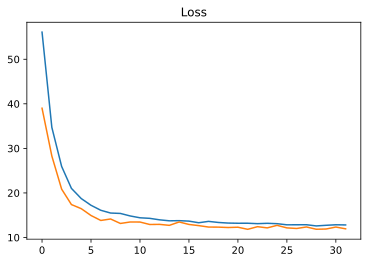

In [72]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [73]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [74]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.95%


TEST mape: 11.95%

In [75]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend 1: Catboost + NLP + Multiple Inputs + Lemmatizing + Pictures

In [76]:
blend_predict_1 = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict_1))*100:0.2f}%")

TEST mape: 11.46%


TEST mape: 11.26%

Kaggle mape: 12.27%

In [77]:
blend_sub_predict_1 = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict_1
sample_submission.to_csv('blend_submission_1.csv', index=False)

# Blend 2: Catboost + Tabular RNN

In [78]:
blend_predict_2 = (test_predict_catboost + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict_2))*100:0.2f}%")

TEST mape: 11.20%


TEST mape: 11.12%

Kaggle mape: 12.17%

In [79]:
blend_sub_predict_2 = (sub_predict_catboost + sub_predict_nn1[:,0]) / 2
sample_submission['price'] = blend_sub_predict_2
sample_submission.to_csv('blend_submission_2.csv', index=False)

# Blend 3: Catboost + RNN + NLP + Multiple Inputs

In [80]:
blend_predict_3 = (test_predict_catboost + test_predict_nn2[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict_3))*100:0.2f}%")

TEST mape: 11.24%


TEST mape: 11.16%

Kaggle mape: 12.22%

In [81]:
blend_sub_predict_3 = (sub_predict_catboost + sub_predict_nn2[:,0]) / 2
sample_submission['price'] = blend_sub_predict_3
sample_submission.to_csv('blend_submission_3.csv', index=False)

# Blend 4: Catboost + RNN + NLP + Multiple Inputs + Lemmatizing

In [82]:
blend_predict_4 = (test_predict_catboost + test_predict_nn2_lemm[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict_4))*100:0.2f}%")

TEST mape: 11.26%


TEST mape: 11.20%

Kaggle mape:

In [83]:
blend_sub_predict_4 = (sub_predict_catboost + sub_predict_nn2_lemm[:,0]) / 2
sample_submission['price'] = blend_sub_predict_4
sample_submission.to_csv('blend_submission_4.csv', index=False)

# Blend 5: LightAutoML + Tabular RNN

In [98]:
blend_predict_5 = (lama_full + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict_5))*100:0.2f}%")

TEST mape: 10.68%


TEST mape: 10.59%

Kaggle mape: 11.08%

### Это лучший из полученных результатов, используем его в качестве финального

In [99]:
blend_sub_predict_5 = (sub_predict_automl + sub_predict_nn1[:,0]) / 2
sample_submission['price'] = blend_sub_predict_5
sample_submission.to_csv('blend_submission_5.csv', index=False)

# Model Bonus: проброс признака

In [84]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [85]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [86]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [87]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_18_input (InputLayer)     [(None, 188)]        0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 512)          96768       dense_18_input[0][0]             
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 512)          0           dense_18[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [88]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [89]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 22ms/step - loss: 99.9852 - MAPE: 99.9852 - val_loss: 99.8312 - val_MAPE: 99.8312
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 98.4661 - MAPE: 98.4661 - val_loss: 92.9790 - val_MAPE: 92.9790
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 77.2920 - MAPE: 77.2920 - val_loss: 50.6853 - val_MAPE: 50.6853
Epoch 4/500
12/12 [==============================] - 0s 8ms/step - loss: 53.3025 - MAPE: 53.3025 - val_loss: 48.6996 - val_MAPE: 48.6996
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 48.7093 - MAPE: 48.7093 - val_loss: 46.4019 - val_MAPE: 46.4019
Epoch 6/500
12/12 [==============================] - 0s 8ms/step - loss: 45.7311 - MAPE: 45.7311 - val_loss: 44.2304 - val_MAPE: 44.2304
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 43.9010 - MAPE: 43.9010 - val_loss: 42.3027 - val_MAPE: 42.3027
Epoch 8/500
12/12 [=====================

In [90]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.98%


TEST mape: 11.69%

### Выводы

Исследовано достаточно большое количество моделей, получены неплохие результаты.

Что можно было-бы улучшить:
- Дополнительный анализ признаков, дополнительная обработка.
- Дополнительный анализ текстов, возможно выбор наиболее характерных фраз и выражений.
- Дальнейшая работа с изображениями, аугментация и предобработка.
- Использование большего набора алгоритмов машинного обучения.
- Более тонкая настройка алгоритмов.

In [133]:
# 